# <center> **HOG Descriptor** </center>
## <font size=4> **Visión por Computadora 2025** </font> <font color=gray size=4> -- Alan Reyes-Figueroa </font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from scipy.signal import correlate2d, convolve2d

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

from skimage.color import rgb2gray, gray2rgb
from skimage import data
from PIL import Image

from time import time 

import cv2

from matplotlib.patches import mlines

# Read Image

In [2]:
I = imread('person.png')
I = I[:,:,:3]
I.shape

(585, 300, 3)

In [3]:
I[0,0]

array([98, 98, 98], dtype=uint8)

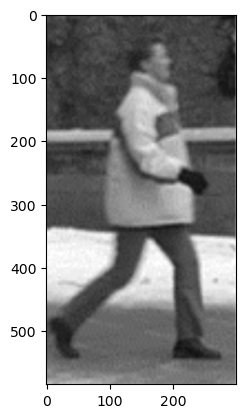

In [4]:
plt.figure()
plt.imshow(I)
plt.show()

In [5]:
factor = 1
rI = resize(I, (128*factor, 64*factor))       # PIL.Image
rI.shape

(128, 64, 3)

In [6]:
rI[0,0]

array([0.29962698, 0.29962892, 0.29962892])

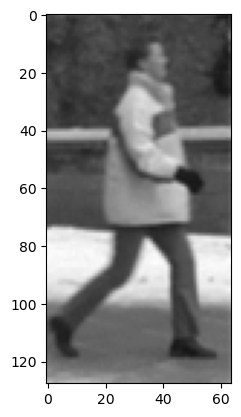

In [7]:
plt.figure()
plt.imshow(rI)
plt.show()

In [8]:
rJ = rgb2gray(rI)
rJ.shape

(128, 64)

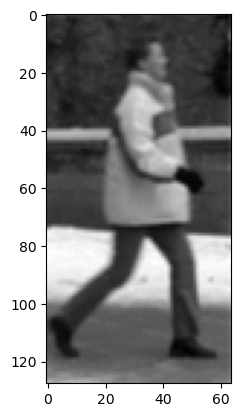

In [9]:
fig = plt.figure()
plt.imshow(rJ, cmap='gray')
plt.show()

In [10]:
rJ[0,0]

0.2996285056559493

In [11]:
#fig.savefig('person_gray.png', bbox_inches='tight')

# Computing HOG step by step

In [12]:
def GaussianFilter(kernel_size, sigma=1., mu=np.zeros(2) ):
    x = np.linspace(-1, 1, kernel_size) 
    y = np.linspace(-1, 1, kernel_size)
    X, Y = np.meshgrid(x, y)
    R2 = (X - mu[0])**2 + (Y - mu[1])**2
    Z = (1./(2. * np.pi * sigma**2)) * np.exp(- R2/(2.*sigma**2)) 
    return Z


def GaussianDerx(kernel_size, sigma=1., mu=np.zeros(2) ):
    x = np.linspace(-1, 1, kernel_size) 
    y = np.linspace(-1, 1, kernel_size)
    X, Y = np.meshgrid(x, y)
    R2 = (X - mu[0])**2 + (Y - mu[1])**2
    Z = -(1./(2. * np.pi * sigma**2)) * np.exp(- R2/(2.*sigma**2)) * ((X-mu[0])/sigma**2)
    return Z


def GaussianDery(kernel_size, sigma=1., mu=np.zeros(2) ):
    x = np.linspace(-1, 1, kernel_size) 
    y = np.linspace(-1, 1, kernel_size)
    X, Y = np.meshgrid(x, y)
    R2 = (X - mu[0])**2 + (Y - mu[1])**2
    Z = -(1./(2. * np.pi * sigma**2)) * np.exp(- R2/(2.*sigma**2)) * ((Y-mu[1])/sigma**2)
    return Z

In [13]:
sz = 15

In [14]:
size = 2*sz + 1
sigma = 0.03

g  = GaussianFilter(size, sigma)
gx = GaussianDerx(size, sigma)
gy = GaussianDery(size, sigma)

In [15]:
print(g.shape, gx.shape, gy.shape)

(31, 31) (31, 31) (31, 31)


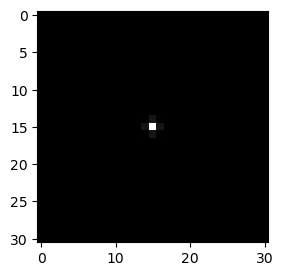

In [16]:
plt.figure(figsize=(3,3))
plt.imshow(g, cmap='gray')
plt.show()

In [17]:
rJ = correlate2d(rJ, g, mode='same')

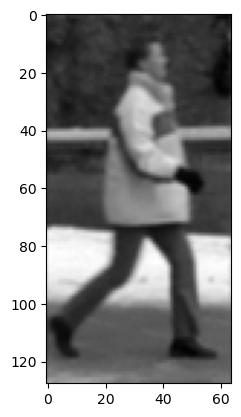

In [18]:
fig = plt.figure()
plt.imshow(rJ, cmap='gray')
plt.show()

## Computing gradients (by convolution)

In [19]:
# Gradient row filters

hy = np.array([[-1,0,1], [-1,0,1], [-1,0,1]])
hx = (hy).T
print(hx.shape, hy.shape, '\n')
print(hx, '\n')
print(hy)

(3, 3) (3, 3) 

[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]] 

[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]


In [20]:
sz = 1
padJ = np.pad(rJ, pad_width=sz, mode='symmetric', reflect_type='even')

In [21]:
Gx = correlate2d(padJ, hx, mode='valid')
Gy = correlate2d(padJ, hy, mode='valid')
print(Gx.shape, Gy.shape)

(128, 64) (128, 64)


In [22]:
# Compute magnitude and angle
magnitude = np.sqrt(Gx**2 + Gy**2)
angle = (np.arctan2(-Gy, Gx) * (180/np.pi)) % 180.    # devuelve ángulos entre [0, 180)

angle = angle % 180.

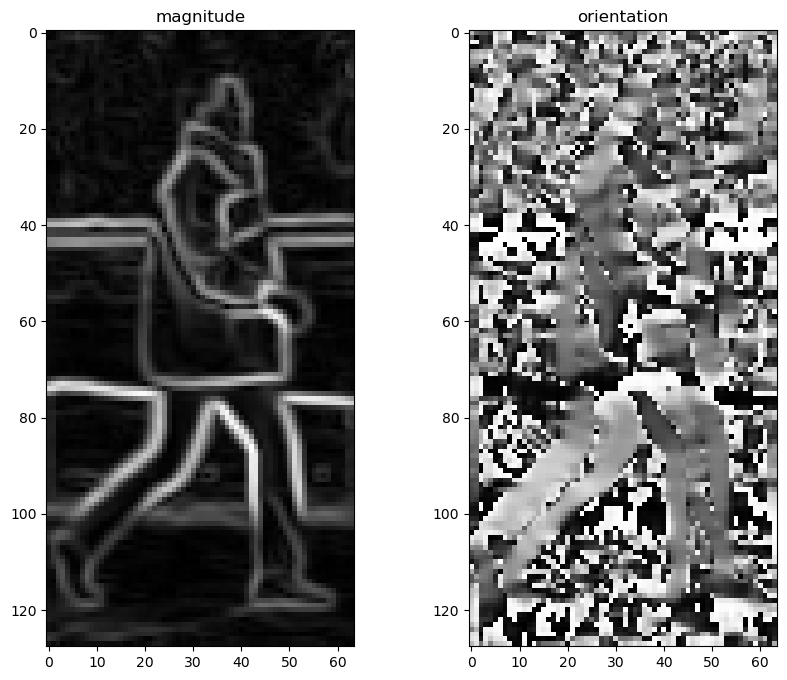

In [23]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(magnitude, cmap='gray')
plt.title('magnitude')
plt.subplot(1,2,2)
plt.imshow(angle, cmap='gray')
plt.title('orientation')
plt.show()

In [24]:
#fig.savefig('gradient.png', bbox_inches='tight')

In [25]:
i = 39
j = 5

In [26]:
print(Gx[i,j], Gy[i,j])

239.163024222312 -6.914723127336742


In [27]:
print(magnitude[i,j])

239.26296318295886


In [28]:
print(np.arctan2(-Gy[i,j], Gx[i,j]) * 180/np.pi)

1.6560842391801698


In [29]:
print(angle.min(), angle.max())

0.01967826451564083 179.9809479854382


In [30]:
print(angle.min(), angle.max())

0.01967826451564083 179.9809479854382


In [31]:
orient = (1 + (((angle / 20.) - 0.5) // 1)).astype(int)

In [32]:
print(orient.min(), orient.max())

0 9


## Convert magnitude and angle to 8x8 blocks

In [33]:
# Convert image to stack of 8x8 blocks (strided by 4)

def image2blocks(I, block_size=8, stride=4):
    M, N = I.shape
    B = []
    
    for i in range(0, (M//stride)-1):
        for j in range(0, (N//stride)-1):
            block = I[i:i+block_size, j:j+block_size]
            B.append(block)

    B = np.array(B)
    return B

In [34]:
stride = 8
mag = image2blocks(magnitude, block_size=8, stride=8)
ang = image2blocks(angle, block_size=8, stride=8)
ori = image2blocks(orient, block_size=8, stride=8)

print(mag.shape, ang.shape, ori.shape)

(105, 8, 8) (105, 8, 8) (105, 8, 8)


## Compute histograms

In [35]:
number_of_bins = 9
step_size = 180 / number_of_bins
     
def Get_j(angle):
    temp = (angle / step_size) - 0.5
    j = np.floor(temp)
    return int(j)
     
def Get_Cj(j):
    Cj = step_size * (j + 0.5)
    return np.round(Cj, 8)
     
def Get_Vj(magnitude, angle, j):
    Cj1 = Get_Cj(j+1)
    Vj = magnitude * ((Cj1 - angle) / step_size)
    return Vj

def Get_Vj1(magnitude, angle, j):
    Cj = Get_Cj(j)
    Vj1 = magnitude * ((angle - Cj) / step_size)
    return Vj1

In [36]:
# Construct histograms of each 8x8 block

Histograms = []
B = mag.shape[0]    # number of blocks

for i in range(0, B):
    temp = []
    mu = mag[i].ravel()
    ot = ori[i].ravel()
    
    hist = np.zeros(2+number_of_bins)
    for k in range(0, len(mu)):
        h = np.zeros(2+number_of_bins)
        j = ot[k]
        Cj  = step_size * (j + 0.5)
        Cj1 = step_size * (j+1 + 0.5)
        h[j]   = mu[k] * ((Cj1 - ot[k]) / step_size)
        h[j+1] = mu[k] * ((ot[k] - Cj) / step_size)
        hist = hist + h
    
    Histograms.append(hist)

Histograms = np.array(Histograms)

In [37]:
Histograms = Histograms[:,1:-1]

In [38]:
Histograms.shape

(105, 9)

In [39]:
Histograms[0]

array([ 385.38443226,  428.87490733,  263.16087552,  -37.78129551,
       1651.59197724,  427.93828988,  945.64865936, -434.16101098,
       -634.45935351])

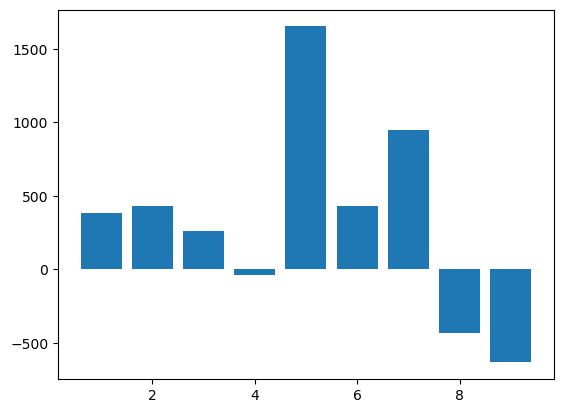

In [40]:
plt.figure()
plt.bar(x=np.arange(1,10), height=Histograms[0])
plt.show()

# Normalize histograms

In [41]:
for i in range(0, Histograms.shape[0]):
    Histograms[i] = Histograms[i] / np.linalg.norm(Histograms[i])

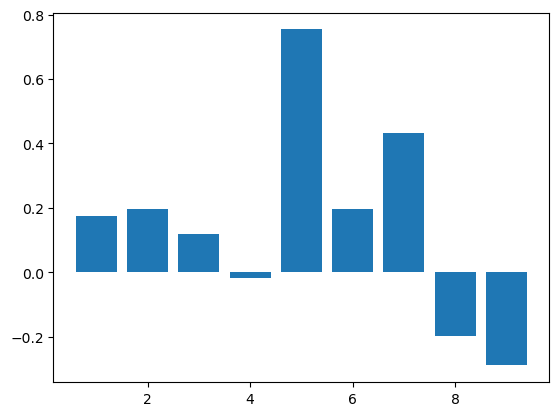

In [42]:
plt.figure()
plt.bar(x=np.arange(1,10), height=Histograms[0])
plt.show()

# Visualization of Histograms

15 7


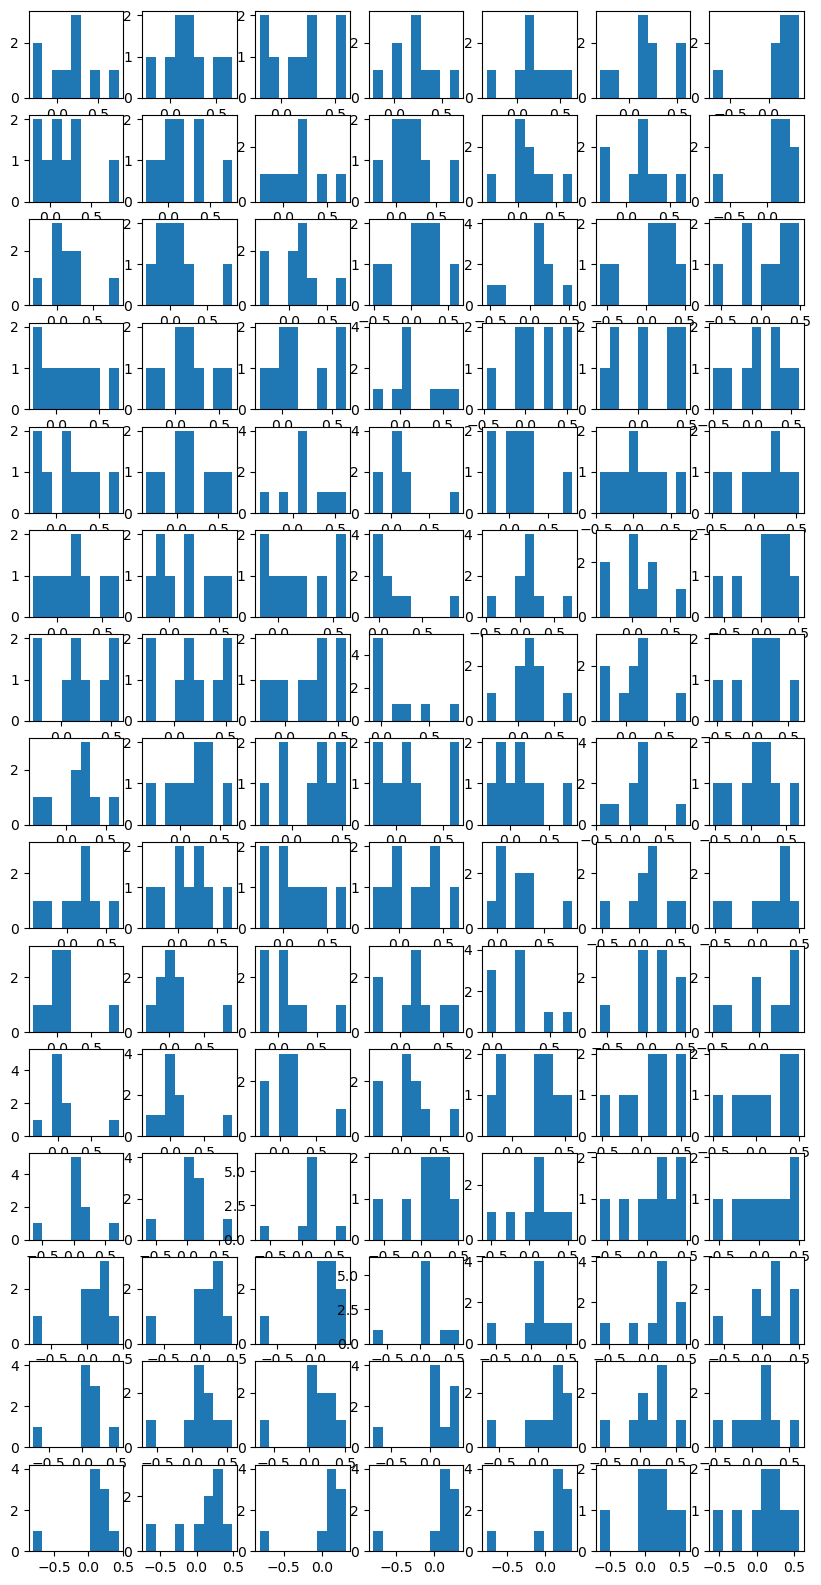

In [43]:
rows = (rJ.shape[0] // stride) - 1
cols = (rJ.shape[1] // stride) - 1
print(rows, cols)
plt.figure(figsize=(10,20))
for i in range(0, rows):
    for j in range(0, cols):
        plt.subplot(rows, cols, cols*i+j+1)
        plt.hist(Histograms[cols*i+j], bins=number_of_bins)
plt.show()

In [44]:
print(Histograms.min(), Histograms.max())

-0.8111185028433333 0.9293697412572551


In [45]:
Histograms.shape

(105, 9)

In [46]:
np.linalg.norm(Histograms, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

# HOG on Scikit-Image

In [47]:
from skimage.feature import hog

In [48]:
fd, hogI = hog(rJ, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

In [49]:
fd.shape

(3780,)

In [50]:
hogI.shape

(128, 64)

In [51]:
np.linspace(0,64*factor-8,cols//2+1)

array([ 0.        , 18.66666667, 37.33333333, 56.        ])

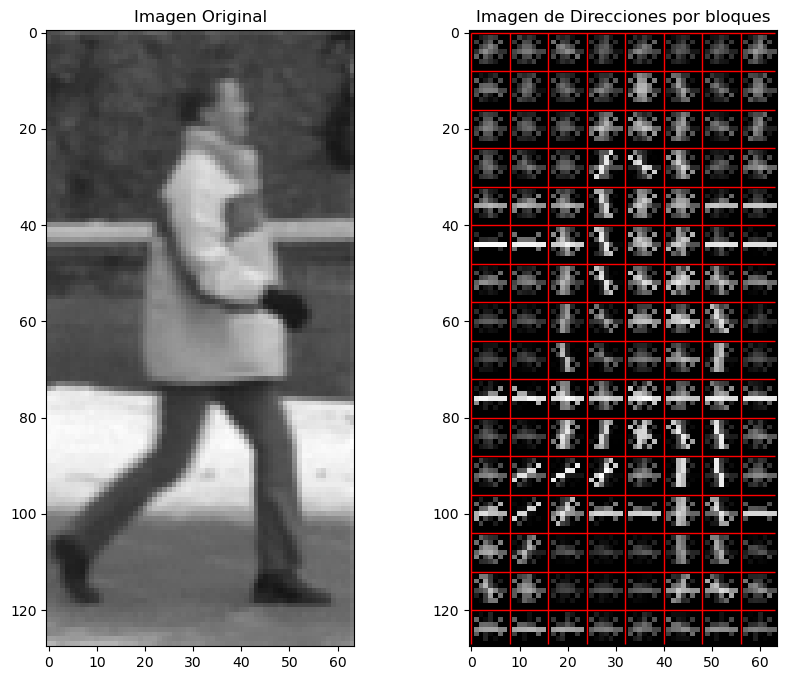

In [52]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(rI, cmap='gray')
plt.title('Imagen Original')
plt.subplot(1,2,2)
plt.imshow(np.log(1.+hogI), cmap='gray')
plt.vlines(x=np.linspace(0,64*factor-8,cols+1), ymin=0, ymax=128*factor-1, lw=1, color='red')
plt.hlines(y=np.linspace(0,128*factor-8,rows+1), xmin=0, xmax=64*factor-1, lw=1, color='red')
plt.title('Imagen de Direcciones por bloques')
plt.show()

In [53]:
#fig.savefig('dir_image.png', bbox_inches='tight')

In [54]:
block = np.zeros((8,8))

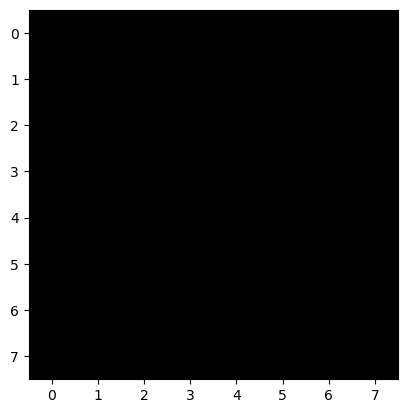

In [55]:
plt.figure()
plt.imshow(block, cmap='gray')
plt.show()

In [56]:
b = 16
x = np.linspace(-8, 8, b)
y = np.linspace(-8, 8, b)
X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape)

(16, 16) (16, 16)


In [57]:
rads = (10 + np.linspace(0,180,10)[:-1]) #* np.pi/180
rads

array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170.])

In [58]:
#W = np.arctan2(X, Y) % np.pi
W = (np.arctan2(-Y, X) * 180/np.pi) % 180
#W[W < 0] = W[W < 0] + np.pi

In [59]:
np.round(W, 0)

array([[135., 131., 126., 121., 115., 108., 101.,  94.,  86.,  79.,  72.,
         65.,  59.,  54.,  49.,  45.],
       [139., 135., 130., 125., 118., 111., 103.,  94.,  86.,  77.,  69.,
         62.,  55.,  50.,  45.,  41.],
       [144., 140., 135., 129., 122., 114., 105.,  95.,  85.,  75.,  66.,
         58.,  51.,  45.,  40.,  36.],
       [149., 145., 141., 135., 128., 119., 108.,  96.,  84.,  72.,  61.,
         52.,  45.,  39.,  35.,  31.],
       [155., 152., 148., 142., 135., 126., 113.,  98.,  82.,  67.,  54.,
         45.,  38.,  32.,  28.,  25.],
       [162., 159., 156., 151., 144., 135., 121., 101.,  79.,  59.,  45.,
         36.,  29.,  24.,  21.,  18.],
       [169., 167., 165., 162., 157., 149., 135., 108.,  72.,  45.,  31.,
         23.,  18.,  15.,  13.,  11.],
       [176., 176., 175., 174., 172., 169., 162., 135.,  45.,  18.,  11.,
          8.,   6.,   5.,   4.,   4.],
       [  4.,   4.,   5.,   6.,   8.,  11.,  18.,  45., 135., 162., 169.,
        172., 174., 17

In [60]:
print(W.min(), W.max())

3.814074834290352 176.18592516570965


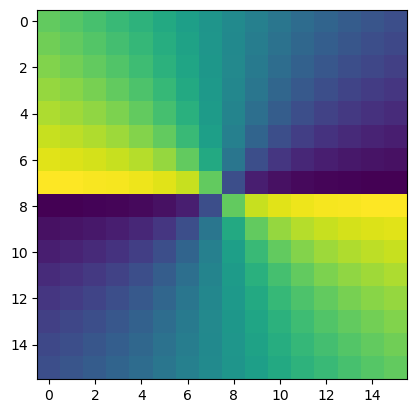

In [61]:
plt.imshow(W)
plt.show()

In [62]:
np.arctan2(-10,1) * 180/np.pi

-84.28940686250037

In [63]:
Z = np.zeros((number_of_bins, b, b)).astype(int)
delta = 5.

Z[0] = (np.abs(W - rads[0]) < delta)
Z[1] = (np.abs(W - rads[1]) < delta)
Z[2] = (np.abs(W - rads[2]) < delta)
Z[3] = (np.abs(W - rads[3]) < delta)
Z[4] = (np.abs(W - rads[4]) < delta)
Z[5] = (np.abs(W - rads[5]) < delta)
Z[6] = (np.abs(W - rads[6]) < delta)
Z[7] = (np.abs(W - rads[7]) < delta)
Z[8] = (np.abs(W - rads[8]) < delta)

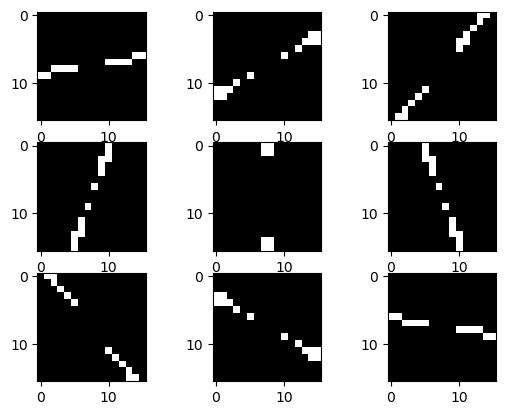

In [64]:
plt.figure()
for i in range(0, 3):
    for j in range(0, 3):
        plt.subplot(3, 3, 3*i+j+1)
        plt.imshow(Z[3*i+j], cmap='gray')
plt.show()